In [2]:
import numpy as np

from math import sqrt
from scipy import *
import scipy.linalg

from numpy.linalg import eig
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM,Bidirectional,RNN,GRU,ConvLSTM2D,TimeDistributed,GlobalMaxPooling2D
import sys
import scipy.linalg
%matplotlib inline

# Loading data

In [3]:
Result=pd.read_csv("..../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=8,num=60000,seed=202,correlation=20.dat", header=None)
Data=pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=8,num=60000,seed=152,correlation=20.dat", header=None)

1D convlstm is not implemented in tensorflow. Therefore, we use 2d convlstm and dont touch the second dimension

In [ ]:
def prepare_data(Result_train1, Data_train1, Result_test1, Data_test1, generalization_steps, extrapolation_steps):
    """
    Prepare the data for training and testing by reshaping and combining input features and output labels.

    Parameters:
    - Result_train (list or array): contains all expectation values for all  Ps (circuit mudules) for training set.
                   it has shape of (number of samples, number of modules*number of observables)
    - Data_train (list or array): Random Guassian parameters theta for all  Ps (circuit mudules) and all qubits for training set .
                    it has shape of (number of samples, number of modules*number of qubits)
    - Result_test (list or array): all expectation values for all  Ps (circuit mudules) for test set.
    - Data_test (list or array): Random Guassian parameters theta for all ps (circuit mudules) and all qubits for test set.
    - generalization_steps (int): Number of generalization steps.
    - extrapolation_steps (int): Number of extrapolation steps.

    Returns:
    - x_train (array): NN's Input for training data.
    - y_train (array): NN's Output for training data.
    - x_test (array): NN's Input for test data.
    - y_test (array): NN's Output for test data.

    Notes:
    - The input of the network is (Theta,p) which has 2 values.  
    - Assumes that the lengths of `Result_train`, `Data_train`, `Result_test`, and `Data_test` are consistent.
    - The output arrays (`x_train`, `y_train`, `x_test`, `y_test`) are formatted based on the specified generalization
      and extrapolation steps.
    """

    Data_train =Data_train1.reshape(len(Data_train1), P_extrapolation,M)# np.array(Data_train1)[:, :generalization_steps]
    Data_test = Data_test1.reshape(len(Data_test1), P_extrapolation,M)#np.array(Data_test1)[:, :extrapolation_steps]
    

    x_train=np.zeros((len(Data_train),P_extrapolation,M,1,2))
    x_test=np.zeros((len(Data_test),P_extrapolation,M,1,2))
    x_train[:,:,:,0,0]=Data_train
    x_test[:,:,:,0,0]=Data_test
    x_train[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_train),axis=1).T)[:,:,np.newaxis],M,axis=2)
    x_test[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test),axis=1).T)[:,:,np.newaxis],M,axis=2)

    

    y_train = Result_train1.reshape(len(Result_train1),  P_extrapolation, 9*(L-1)+3*L)
    y_test = Result_test1.reshape(len(Result_test1), P_extrapolation, 9*(L-1)+3*L)



    return x_train, y_train, x_test, y_test


def build_convlstm_model(batch_input_shape):
    """
    the input of the network has the shape (number of samples, number of circuit modules, number
    of qubits, and number of features). Our feature set comprises two elements: the parameter θ_p and p itself. 
    the output of the network is expectation value of the ovservables 9(L-1)+3*L with L=int((M-1)/2)+1 and M number
    of qubits
    """
    net = Sequential()
    net.add(ConvLSTM2D(filters=70, kernel_size=(kernel, kernel),data_format='channels_last'
                    , batch_input_shape=(None,None,None,None,Num_inp_features)
                    , return_sequences=True,padding='same')) 
    net.add(ConvLSTM2D(filters=100, kernel_size=(kernel, kernel),data_format='channels_last'
                    , return_sequences=True,padding='same')) 

    net.add(ConvLSTM2D(filters=100, kernel_size=(kernel, kernel),data_format='channels_last'
                        , return_sequences=True,padding='same'))
    # net.add(ConvLSTM2D(filters=100, kernel_size=(kernel, kernel),data_format='channels_last'
    #                     , return_sequences=True,padding='same'))
    net.add(ConvLSTM2D(filters=70, kernel_size=(kernel, kernel),data_format='channels_last'
                    , return_sequences=True,padding='same')) 
    net.add(ConvLSTM2D(filters=3*L+9*(L-1), kernel_size=(kernel, kernel),data_format='channels_last'
                    , return_sequences=True,padding='same'))
    net.add(TimeDistributed((GlobalMaxPooling2D( data_format='channels_last'))))
    net.compile(loss='mean_squared_error', optimizer='adam',metrics=['mean_squared_error'])
    return net

def plot_training_history(history):
    plt.plot(history.history['val_mean_squared_error'], linewidth=3)
    plt.plot(history.history['mean_squared_error'], linewidth=3)
    legend = plt.legend(('MSE_validation', 'MSE_train'))
    plt.xlabel('number of epochs', fontsize=21)
    plt.ylabel('MSE', fontname="cal", fontweight="bold", fontsize=25)
    plt.title('M=8, LSTM', fontsize=25)
    plt.show()
    plt.yscale('log')



P_generalization = 20
P_extrapolation = 40
generalization_steps = 20
extrapolation_steps = 40
Plist_generalization=np.arange(P_generalization)
Plist_extrapolation=np.arange(P_extrapolation)

M = 8
L = int((M-1)/2)+1
Num_inp_features=2
kernel=3

Result_train1=np.array(Result)[:59000]
Data_train1=np.array(Data)[:59000]
Data_test1=np.array(Data)[59000:600000]
Result_test1=np.array(Result)[59000:600000]

# Data Preparation
x_train, y_train, x_test, y_test = prepare_data(Result_train1, Data_train1, Result_test1, Data_test1, generalization_steps, extrapolation_steps)


# Model Creation
batch_input_shape=(None,P_extrapolation,None,None,Num_inp_features) # Shape of input data (Theta, <sz,t=0>, <sy,t=0>, <sx,t=0>, time)
net = build_convlstm_model(batch_input_shape)


Model Training
history=(net.fit(x=x_train[:,:P_generalization,:,:,:],y=y_train[:,:P_generalization,:],batch_size=1000,epochs=1, validation_split=0.01))
# Model Evaluation
error = net.evaluate(x=x_test, y=y_test)

In [7]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, None, None,  181720    
                              70)                                
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, None, None,  612400    
                              100)                               
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, None, None, None,  720400    
                              100)                               
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, None, None, None,  428680    
                              70)                                
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, None, None,  1

32/32 [==============================] - 7s 185ms/step - loss: 0.0119 - mean_squared_error: 0.0119


findfont: Font family ['cal'] not found. Falling back to DejaVu Sans.


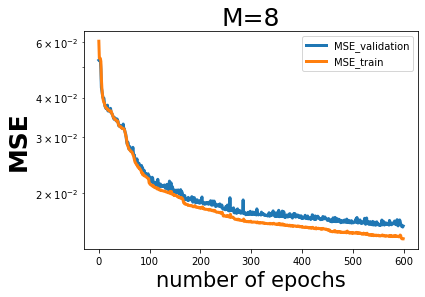

In [7]:
#100000
#kernel 3
y_predict = net.predict(x_test)
   
error=net.evaluate(x=x_test,y=y_test)
plt.plot(history.history['val_mean_squared_error'], linewidth=3)
plt.plot(history.history['mean_squared_error'], linewidth=3)
legend=plt.legend(('MSE_validation','MSE_train'))
plt.xlabel('number of epochs',fontsize=21)
plt.ylabel('MSE',fontname="cal",fontweight="bold",fontsize=25)
plt.title('M=8',fontsize=25)
plt.yscale('log')
plt.show()

In [27]:
y_predict = net.predict(x_test)
   
error=net.evaluate(x=x_test,y=y_test)

32/32 [==============================] - 4s 126ms/step - loss: 0.0185 - mean_squared_error: 0.0185


In [19]:
Result_train=np.array(Result)[:59000]
Data_train=np.array(Data)[:59000]
Data_test=np.array(Data)[59000:600000]
Result_test=np.array(Result)[59000:600000]

# test data for larger number of qubits=10,12,18,20,24

In [ ]:
K=40
M5=5
M6=6
M9=9
M10=10
M12=12
L=8


Result_test_5=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=10,num=10,seed=156,correlation=20.dat", header=None))
Data_test_5=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=10,num=10,seed=156,correlation=20.dat", header=None))

Result_test_6=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=12,num=10,seed=160,correlation=20.dat", header=None))
Data_test_6=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=12,num=10,seed=160,correlation=20.dat", header=None))


Result_test_9=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=18,num=10,seed=172,correlation=20.dat", header=None))
Data_test_9=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=18,num=10,seed=172,correlation=20.dat", header=None))

Result_test_10=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=20,num=4,seed=176,correlation=20.dat", header=None))
Data_test_10=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=20,num=4,seed=176,correlation=20.dat", header=None))

Result_test_12=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Expects_k=40,M=24,num=4,seed=185,correlation=20.dat", header=None))
Data_test_12=np.array(pd.read_csv(".../closed_more_obs_inhomogenious_zz_z_x_Theta_k=40,M=24,num=4,seed=185,correlation=20.dat", header=None))



data_test_5=Data_test_5.reshape(len(Data_test_5), K,2*M5)
data_test_6=Data_test_6.reshape(len(Data_test_6), K,2*M6)
data_test_9=Data_test_9.reshape(len(Data_test_9), K,2*M9)
data_test_10=Data_test_10.reshape(len(Data_test_10), K,2*M10)
data_test_12=Data_test_12.reshape(len(Data_test_12), K,2*M12)

x_test_5=np.zeros((len(data_test_5),K,2*M5,1,2))
x_test_6=np.zeros((len(Data_test_6),K,2*M6,1,2))
x_test_9=np.zeros((len(Data_test_9),K,2*M9,1,2))
x_test_10=np.zeros((len(Data_test_10),K,2*M10,1,2))
x_test_12=np.zeros((len(Data_test_12),K,2*M12,1,2))

x_test_5[:,:,:,0,0]=data_test_5
x_test_6[:,:,:,0,0]=data_test_6
x_test_9[:,:,:,0,0]=data_test_9
x_test_10[:,:,:,0,0]=data_test_10
x_test_12[:,:,:,0,0]=data_test_12




x_test_5[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test_5),axis=1).T)[:,:,np.newaxis],2*M5,axis=2)
x_test_6[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test_6),axis=1).T)[:,:,np.newaxis],2*M6,axis=2)
x_test_9[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test_9),axis=1).T)[:,:,np.newaxis],2*M9,axis=2)
x_test_10[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test_10),axis=1).T)[:,:,np.newaxis],2*M10,axis=2)
x_test_12[:,:,:,0,1]=np.repeat((np.repeat(Plist_extrapolation[:,np.newaxis],len(x_test_12),axis=1).T)[:,:,np.newaxis],2*M12,axis=2)



y_test_5=np.array(Result_test_5).reshape(len(Result_test_5),len(taulist),9*(L-1)+3*L)
y_test_6=np.array(Result_test_6).reshape(len(Result_test_6),len(taulist),9*(L-1)+3*L)
y_test_9=np.array(Result_test_9).reshape(len(Result_test_9),len(taulist),9*(L-1)+3*L)
y_test_10=np.array(Result_test_10).reshape(len(Result_test_10),len(taulist),9*(L-1)+3*L)
y_test_12=np.array(Result_test_12).reshape(len(Result_test_12),len(taulist),9*(L-1)+3*L)


In [ ]:
y_predict = net.predict(x_test)
   
error=net.evaluate(x=x_test,y=y_test)

2023-01-29 20:34:27.196748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 20:34:28.772856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


32/32 [==============================] - 8s 200ms/step - loss: 0.0108 - mean_squared_error: 0.0108


In [ ]:
y_predict_12 = net.predict(x_test_12)
   
error=net.evaluate(x=x_test_12,y=y_test_12)

1/1 [==============================] - 0s 236ms/step - loss: 0.0303 - mean_squared_error: 0.0303


In [ ]:
y_predict_10 = net.predict(x_test_10)
   
error=net.evaluate(x=x_test_10,y=y_test_10)

1/1 [==============================] - 1s 1s/step - loss: 0.0235 - mean_squared_error: 0.0235


In [ ]:
# trained up to 20
y_predict_5 = net.predict(x_test_5)
   
error=net.evaluate(x=x_test_5,y=y_test_5)

1/1 [==============================] - 0s 202ms/step - loss: 0.0197 - mean_squared_error: 0.0197


In [ ]:
# trained up to 20
y_predict_6 = net.predict(x_test_6)
   
error=net.evaluate(x=x_test_6,y=y_test_6)

1/1 [==============================] - 0s 205ms/step - loss: 0.0189 - mean_squared_error: 0.0189


In [ ]:
y_predict_10 = net.predict(x_test_10)
   
error=net.evaluate(x=x_test_10,y=y_test_10)

1/1 [==============================] - 0s 204ms/step - loss: 0.0235 - mean_squared_error: 0.0235


# Generalization for system size=8 and extrapolation in circuit depth from p=[1,20] to [20,40]

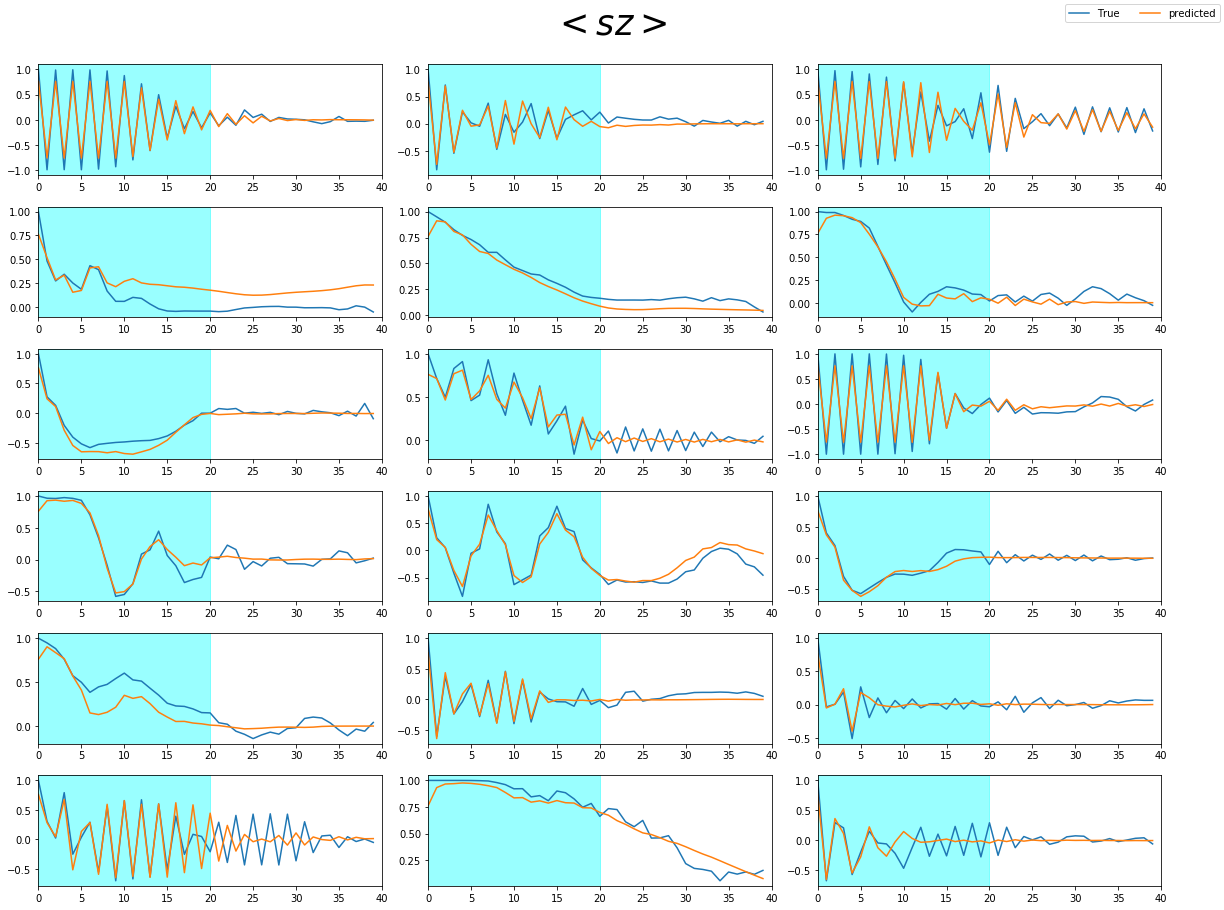

In [40]:
# 60000 samples zz_z_xr
l=2*L+2
fig, axes = plt.subplots(6, 3, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sz>$' ,size=35, y=1.05)
for j in range(3):
    for k in range(6*j,6*(j+1)):
        
        axes[k-6*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_predict),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-6*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-6*j,j].set_xlim(0,40)
        
legend=fig.legend(('True','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)


###  Extrapolation in size from system size 8 to 20 and extrapolation in circuit depth from p=[1,20] to [20,40] for four random realizations

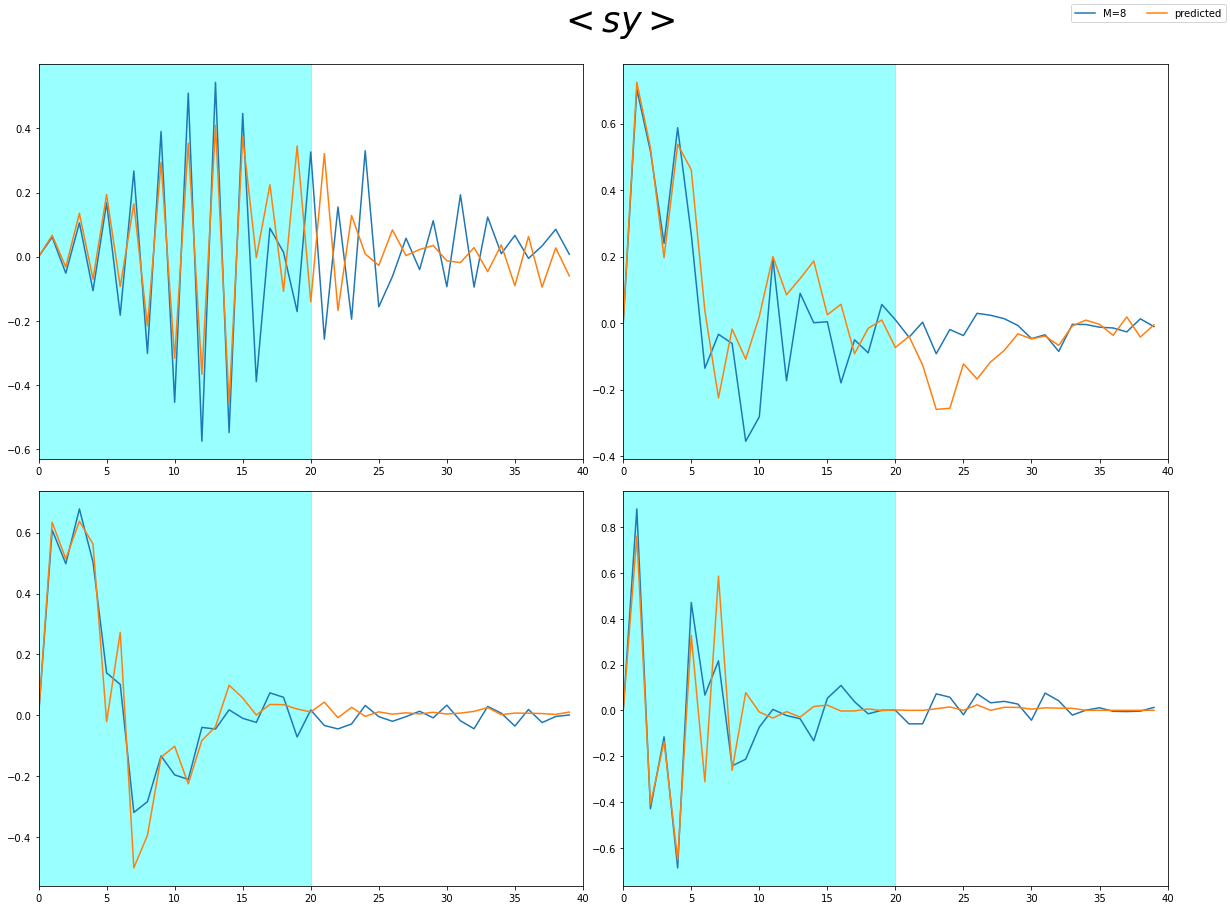

In [36]:
# 60000 samples zz_z_xr
l=L+1
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sy>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test_10),1,2)[k][l])
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_predict_10),1,2)[k][l])
        
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)



###  Extrapolation in size from system size 8 to 24 and extrapolation in circuit depth from p=[1,20] to [20,40] for two random realizations

IndexError: index 2 is out of bounds for axis 0 with size 2

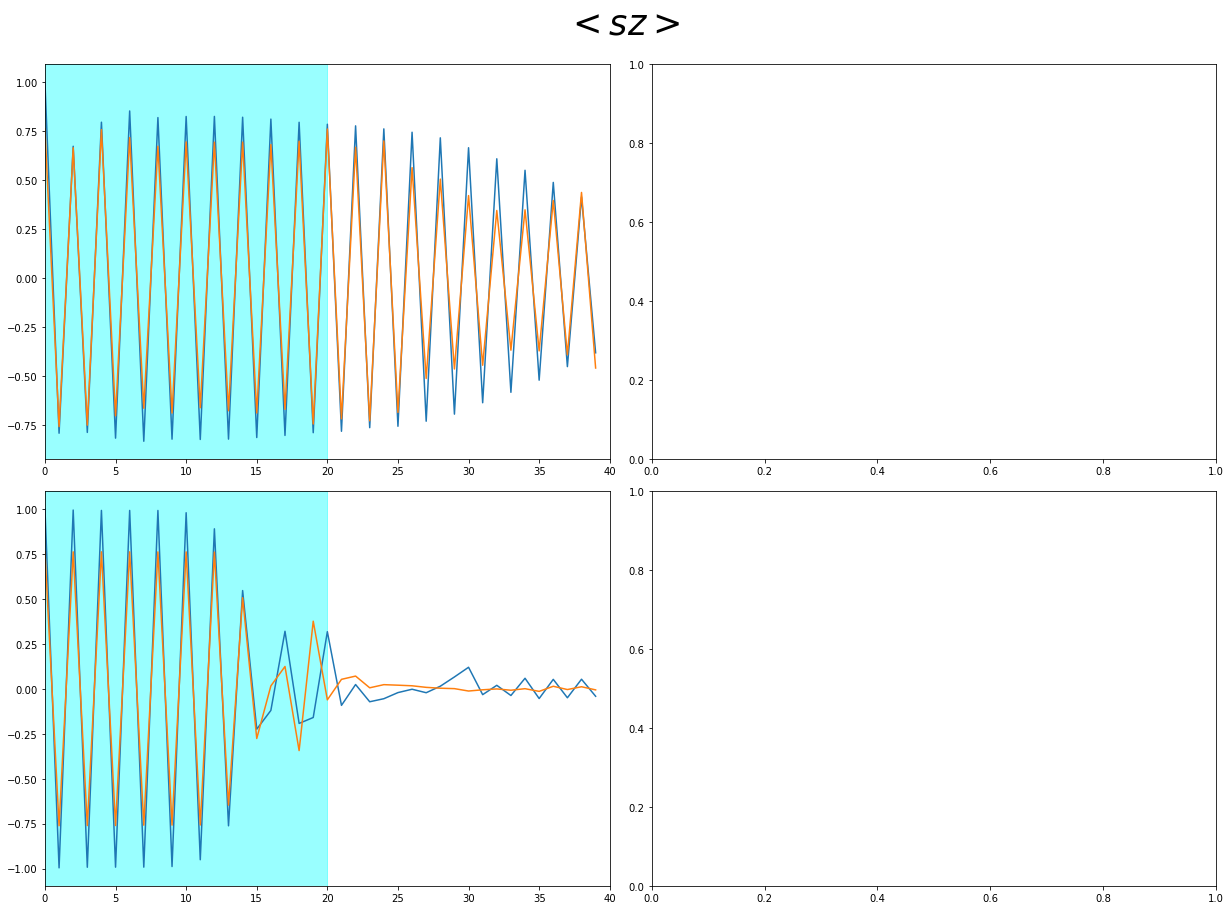

In [36]:
# 60000 samples zz_z_xr
l=2*L+1
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sz>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test_12),1,2)[k][l])
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_predict_12),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)



IndexError: index 2 is out of bounds for axis 0 with size 2

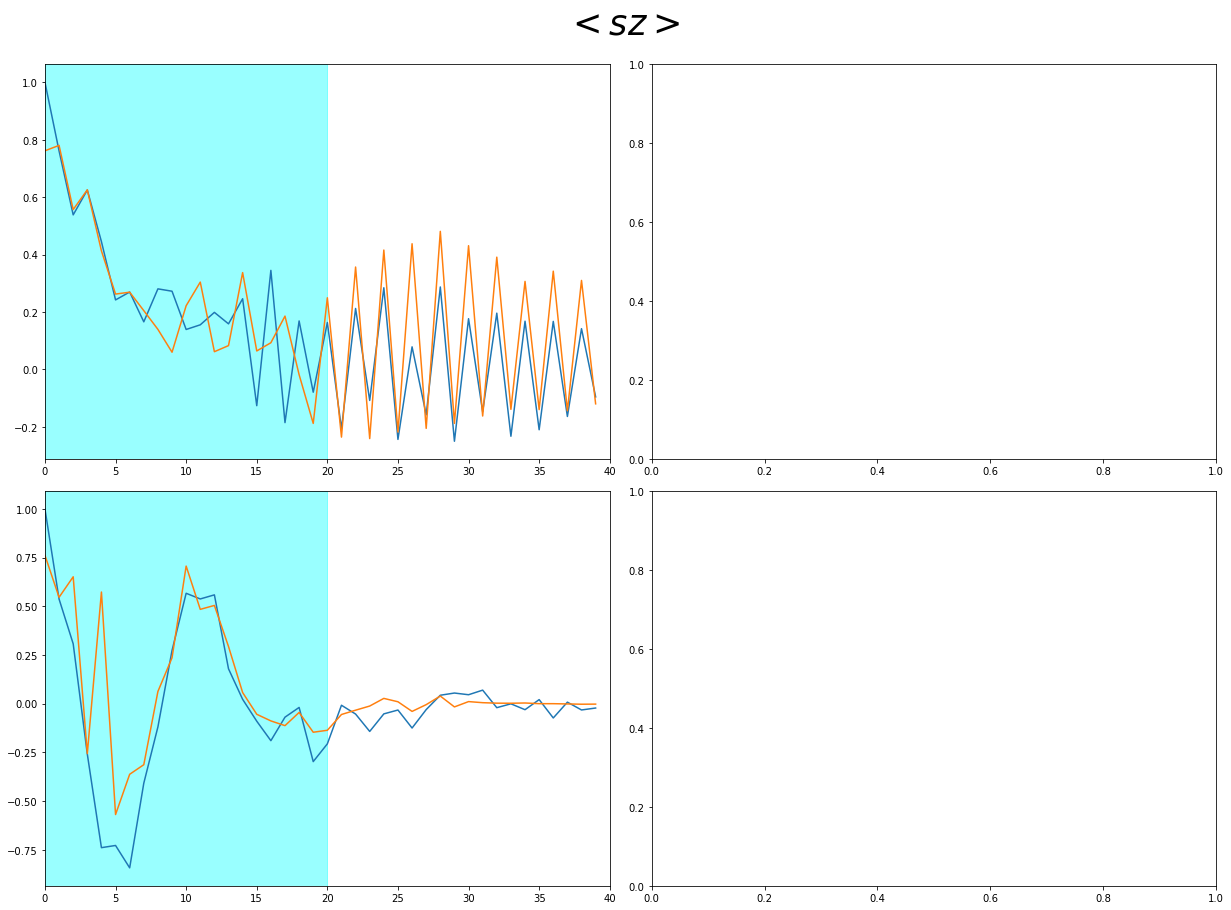

In [37]:
# 60000 samples zz_z_xr
l=2*L+3
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sz>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test_12),1,2)[k][l])
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_predict_12),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)



IndexError: index 2 is out of bounds for axis 0 with size 2

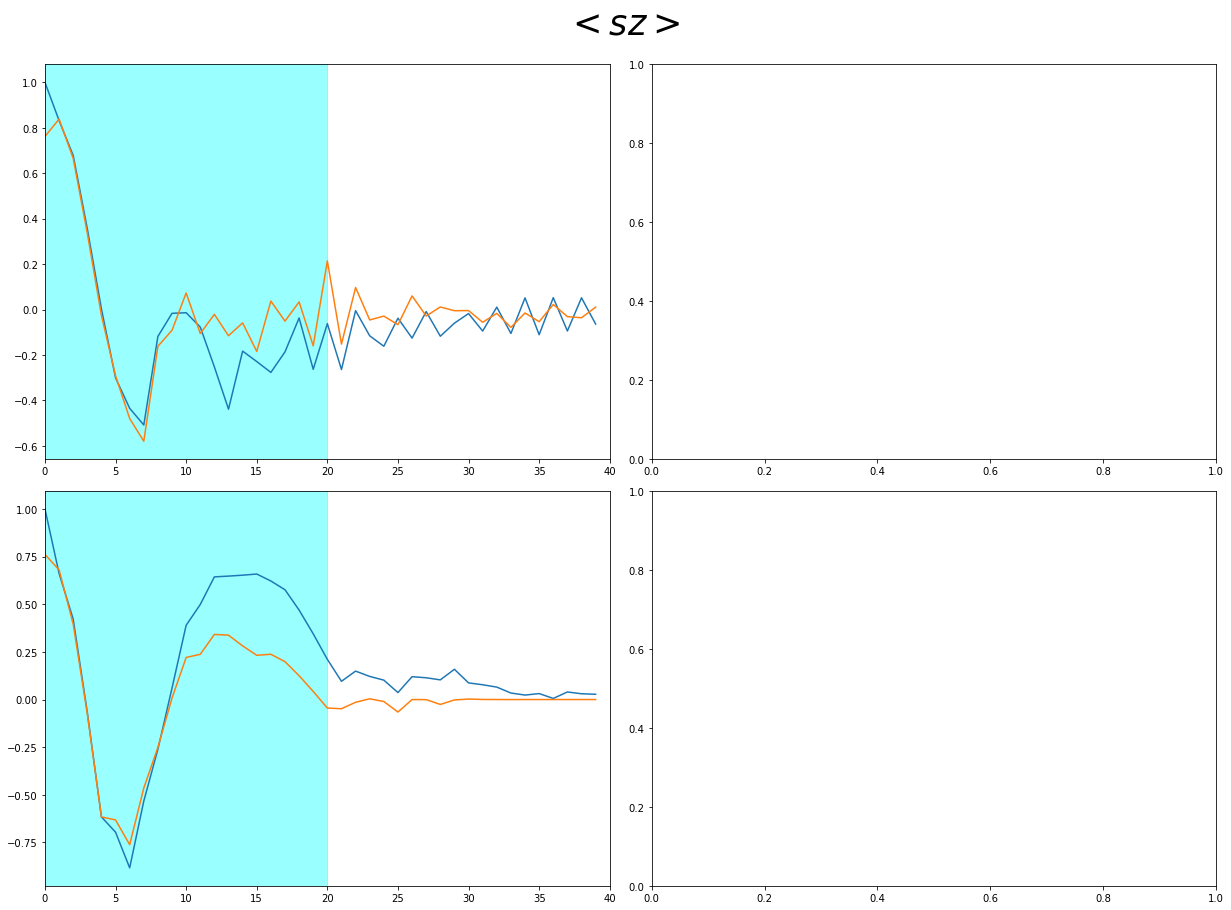

In [38]:
# 60000 samples zz_z_xr
l=2*L+2
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sz>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_test_12),1,2)[k][l])
        axes[k-2*j,j].plot(Plist_extrapolation,np.swapaxes(np.array(y_predict_12),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)



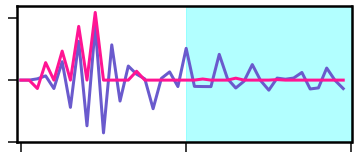

In [221]:
K=40
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['ytick.major.size'] = 9.5
mpl.rcParams['xtick.major.size'] = 9.5
fig, axes = plt.subplots(figsize=(6,2.5))
color='black'
plt.setp(axes.spines.values(), color=color)
plt.setp(axes.spines.values(), linewidth=5)

for axis in ['top', 'bottom', 'left', 'right']:

    axes.spines[axis].set_linewidth(2.5)

plt.tick_params(labelsize=25)
k=0
l=2#3*L+8*(L-1)+2

plt.plot(Plist_extrapolation,np.swapaxes(np.array(y_test_10),1,2)[k][l],linewidth=3,color='slateblue')
plt.plot(Plist_extrapolation,np.swapaxes(np.array(y_predict_10),1,2)[k][l],linewidth=3,color='deeppink')

plt.axvspan(20, 40, color='cyan', alpha=0.3)
plt.xticks([0,20,40])
plt.yticks([-0.5,0,0.5])
plt.xlim(-0.5,40)
#plt.ylim(-0.5,0.4)
axes.tick_params(width=1.5,labelbottom=False,axis='x')
axes.tick_params(width=1.5,labelleft=False,axis='y')
axes.tick_params(width=1.5)
#plt.xlabel('Number of modules',size=20)
fig.savefig('zz_z_x_sz_24_sx.pdf', transparent=True,format='pdf',bbox_inches='tight')

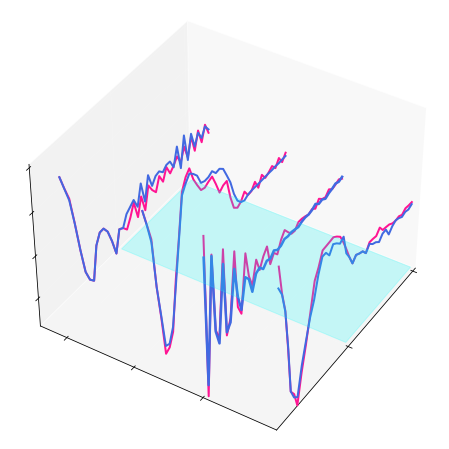

In [193]:





from mpl_toolkits.mplot3d import Axes3D
from matplotlib import  transforms
import matplotlib as mpl
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle, PathPatch
#%matplotlib notebook
step_size=120
tau_max=15
color='black'
taulist=np.arange(0,40,1)
mpl.rcParams['ytick.major.size'] = 18.5
mpl.rcParams['xtick.major.size'] = 18.5


fig = plt.figure(figsize=(11,8),)
axis = plt.subplot(projection='3d')
plt.tick_params(color=color, labelcolor=color)
plt.tick_params(labelsize=25)

axis.w_xaxis.line.set_color(color)
axis.w_yaxis.line.set_color(color)
axis.w_zaxis.line.set_color(color)
mpl.rc('grid', color='gray')
axis.tick_params(axis='z', which='major', pad=15)
axis.zaxis.set_rotate_label(False)


k=1


l=2*L+2


axis.plot(taulist,np.full(len(taulist),0),np.swapaxes(np.array(y_test_12),1,2)[k][l],linewidth=2.0,color='deeppink')

axis.plot(taulist,np.full(len(taulist),0.3),np.swapaxes(np.array(y_test_10),1,2)[k][l],linewidth=2.0,color='deeppink')
axis.plot(taulist,np.full(len(taulist),0.55),np.swapaxes(np.array(y_test_6),1,2)[3][l],linewidth=2.0,color='deeppink')
axis.plot(taulist,np.full(len(taulist),0.9),np.swapaxes(np.array(y_test_5),1,2)[0][l],linewidth=2.0,color='deeppink')

axis.plot(taulist,np.full(len(taulist),0),np.swapaxes(np.array(y_predict_12),1,2)[k][l],linewidth=2.0,color='royalblue')

axis.plot(taulist,np.full(len(taulist),0.3),np.swapaxes(np.array(y_predict_10),1,2)[k][l],linewidth=2.5,color='royalblue')
axis.plot(taulist,np.full(len(taulist),0.55),np.swapaxes(np.array(y_predict_6),1,2)[3][l],linewidth=2.0,color='royalblue')
axis.plot(taulist,np.full(len(taulist),0.9),np.swapaxes(np.array(y_predict_5),1,2)[0][l],linewidth=2.0,color='royalblue')









axis.set_xticks([0,20,40])
plt.yticks([0,0.3,0.6,0.9])
axis.set_zticks([-0.5,0,0.5,1])
axis.view_init(elev=40, azim=-148.0)
axis.tick_params(width=1.5,labelbottom=False)
axis.tick_params(width=1.5,labelleft=False)
xmin=20
xmax=40
ymin=0
ymax=1
HL= Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin), color='cyan', alpha=0.2)
axis.add_patch(HL)
art3d.pathpatch_2d_to_3d(HL, z=-0.8, zdir='z')


#axis.set_xlabel('Jt',fontsize=40,color=color,labelpad=30)
axis.set_xlim3d(0.3, 40)
#axis.set_zlabel(r'$\langle \sigma_{x_i} \rangle$',fontsize=40,color=color,fontweight="bold",labelpad=50,rotation=90)
axis.set_ylim3d(0.01, 1)
#axis.set_ylabel('M',fontsize=40,color=color,labelpad=30)
axis.set_zlim3d(-0.8, 1)


axis.xaxis._axinfo["grid"]['color'] = "w"
axis.zaxis._axinfo["grid"]['color'] = "w"
#axis.zaxis._axinfo["grid"]['linestyle'] = ":"
axis.yaxis._axinfo["grid"]['color'] = "w"
#axis.yaxis._axinfo["grid"]['linestyle'] = ":"
axis.zaxis._axinfo["grid"]['linewidth'] = 0.1
axis.yaxis._axinfo["grid"]['linewidth'] = 0.1
axis.xaxis._axinfo["grid"]['linewidth'] = 0.1
axis.w_xaxis.set_pane_color='pink'

axis.xaxis.pane.fill = 'pink'
axis.xaxis.pane.set_edgecolor('w')
axis.yaxis.pane.set_edgecolor('w')
axis.zaxis.pane.set_edgecolor('w')
fig.savefig('3d_size_extrapolation_sz.pdf',transparent=True, format='pdf',bbox_inches='tight')
plt.show()




In [49]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axis3d as axis3d

# New axis settings
custom_AXINFO = {
    'x': {'i': 0, 'tickdir': 1, 'juggled': (1, 0, 2),
          'color': (0.00, 0.00, 0.25, .75)},
    'y': {'i': 1, 'tickdir': 0, 'juggled': (0, 1, 2),
          'color': (0.20, 0.90, 0.90, 0.25)},
    'z': {'i': 2, 'tickdir': 0, 'juggled': (0, 2, 1),
          'color': (0.925, 0.125, 0.90, 0.25)},}

class custom_XAxis(axis3d.Axis):
    _AXINFO = custom_AXINFO

class custom_YAxis(axis3d.Axis):
    _AXINFO = custom_AXINFO

class custom_ZAxis(axis3d.Axis):
    _AXINFO = custom_AXINFO

class custom_Axes3D(Axes3D):
    def _init_axis(self):
        '''Init 3D axes; overrides creation of regular X/Y axes'''
        self.w_xaxis = custom_XAxis('x', self.xy_viewLim.intervalx,
                                    self.xy_dataLim.intervalx, self)
        self.xaxis = self.w_xaxis
        self.w_yaxis = custom_YAxis('y', self.xy_viewLim.intervaly,
                            self.xy_dataLim.intervaly, self)
        self.yaxis = self.w_yaxis
        self.w_zaxis = custom_ZAxis('z', self.zz_viewLim.intervalx,
                            self.zz_dataLim.intervalx, self)
        self.zaxis = self.w_zaxis

        for axis in self.xaxis, self.yaxis, self.zaxis:
            axis.init3d()

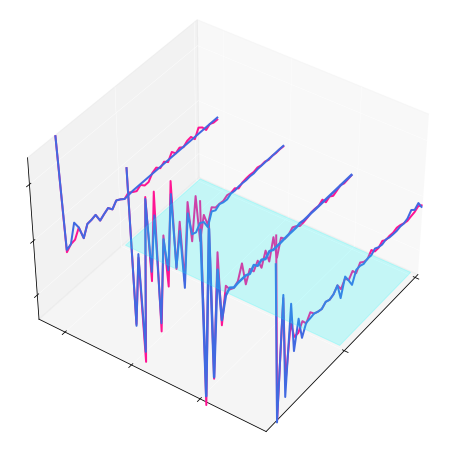

In [202]:





from mpl_toolkits.mplot3d import Axes3D
from matplotlib import  transforms
import matplotlib as mpl
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Rectangle, PathPatch
#%matplotlib notebook
step_size=120
tau_max=15
color='black'
taulist=np.arange(0,40,1)
mpl.rcParams['ytick.major.size'] = 18.5
mpl.rcParams['xtick.major.size'] = 18.5


fig = plt.figure(figsize=(11,8),)
axis = plt.subplot(projection='3d')
plt.tick_params(color=color, labelcolor=color)
plt.tick_params(labelsize=25)

axis.w_xaxis.line.set_color(color)
axis.w_yaxis.line.set_color(color)
axis.w_zaxis.line.set_color(color)
mpl.rc('grid', color='gray')
axis.tick_params(axis='z', which='major', pad=15)
axis.zaxis.set_rotate_label(False)


k=1


l=3*L+8*(L-1)+2


axis.plot(taulist,np.full(len(taulist),0),np.swapaxes(np.array(y_test_12),1,2)[0][l],linewidth=2.0,color='deeppink')

axis.plot(taulist,np.full(len(taulist),0.3),np.swapaxes(np.array(y_test_10),1,2)[3][l],linewidth=2.0,color='deeppink')
axis.plot(taulist,np.full(len(taulist),0.6),np.swapaxes(np.array(y_test_6),1,2)[2][l],linewidth=2.0,color='deeppink')
axis.plot(taulist,np.full(len(taulist),0.9),np.swapaxes(np.array(y_test_5),1,2)[5][l],linewidth=2.0,color='deeppink')

axis.plot(taulist,np.full(len(taulist),0),np.swapaxes(np.array(y_predict_12),1,2)[0][l],linewidth=2.0,color='royalblue')

axis.plot(taulist,np.full(len(taulist),0.3),np.swapaxes(np.array(y_predict_10),1,2)[3][l],linewidth=2.5,color='royalblue')
axis.plot(taulist,np.full(len(taulist),0.6),np.swapaxes(np.array(y_predict_6),1,2)[2][l],linewidth=2.0,color='royalblue')
axis.plot(taulist,np.full(len(taulist),0.9),np.swapaxes(np.array(y_predict_5),1,2)[5][l],linewidth=2.0,color='royalblue')









axis.set_xticks([0,20,40])
plt.yticks([0,0.3,0.6,0.9])
axis.set_zticks([-0.5,0,0.5,1])
axis.view_init(elev=40, azim=-145.0)
axis.tick_params(width=1.5,labelbottom=False)
axis.tick_params(width=1.5,labelleft=False)
xmin=20
xmax=40
ymin=0.04
ymax=1
HL= Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin), color='cyan', alpha=0.2)
axis.add_patch(HL)
art3d.pathpatch_2d_to_3d(HL, z=-0.7, zdir='z')
mpl.rcParams['lines.linewidth'] = 1
#axis.rcParams['grid.color'] = "deeppink"
#axis.set_xlabel('Jt',fontsize=40,color=color,labelpad=30)
axis.set_xlim3d(0.3, 40)
#axis.set_zlabel(r'$\langle \sigma_{x_i} \rangle$',fontsize=40,color=color,fontweight="bold",labelpad=50,rotation=90)
axis.set_ylim3d(0.04, 1)
#axis.set_ylabel('M',fontsize=40,color=color,labelpad=30)
axis.set_zlim3d(-0.7, 0.7)
#fig.savefig('3d_size_extrapolation_szsx.pdf',transparent=True, format='pdf',bbox_inches='tight')

axis.xaxis._axinfo["grid"]['color'] = "w"
axis.zaxis._axinfo["grid"]['color'] = "w"
#axis.zaxis._axinfo["grid"]['linestyle'] = ":"
axis.yaxis._axinfo["grid"]['color'] = "w"
#axis.yaxis._axinfo["grid"]['linestyle'] = ":"
axis.zaxis._axinfo["grid"]['linewidth'] = 0.4
axis.yaxis._axinfo["grid"]['linewidth'] = 0.4
axis.xaxis._axinfo["grid"]['linewidth'] = 0.4
fig.savefig('3d_size_extrapolation_szsx.pdf',transparent=True, format='pdf',bbox_inches='tight')
#axis = custom_Axes3D(fig)
plt.show()




IndexError: index 2 is out of bounds for axis 0 with size 2

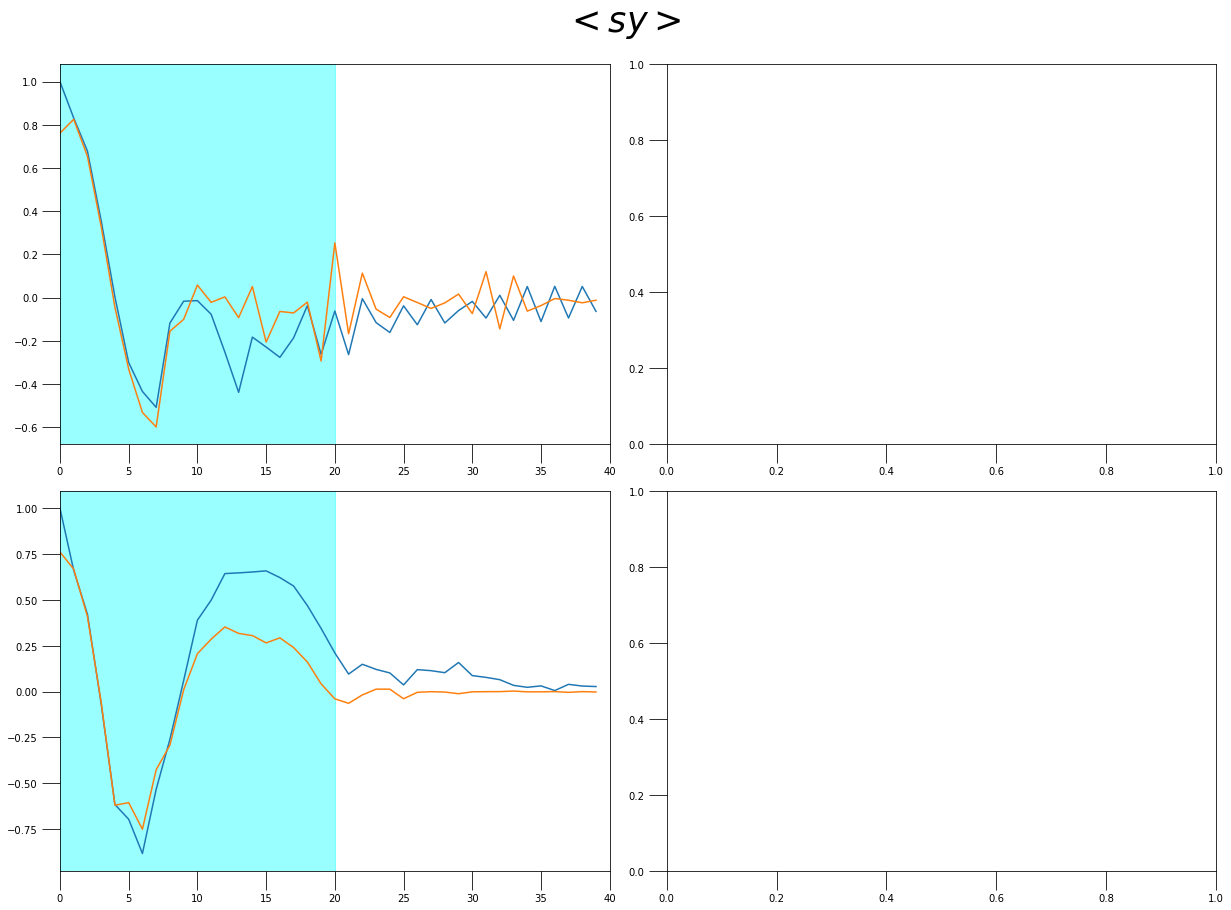

In [25]:
# 60000 samples zz_z_xr
l=2*L+2
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sy>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(taulist,np.swapaxes(np.array(y_test_12),1,2)[k][l])
        axes[k-2*j,j].plot(taulist,np.swapaxes(np.array(y_predict_12),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)



IndexError: index 2 is out of bounds for axis 0 with size 2

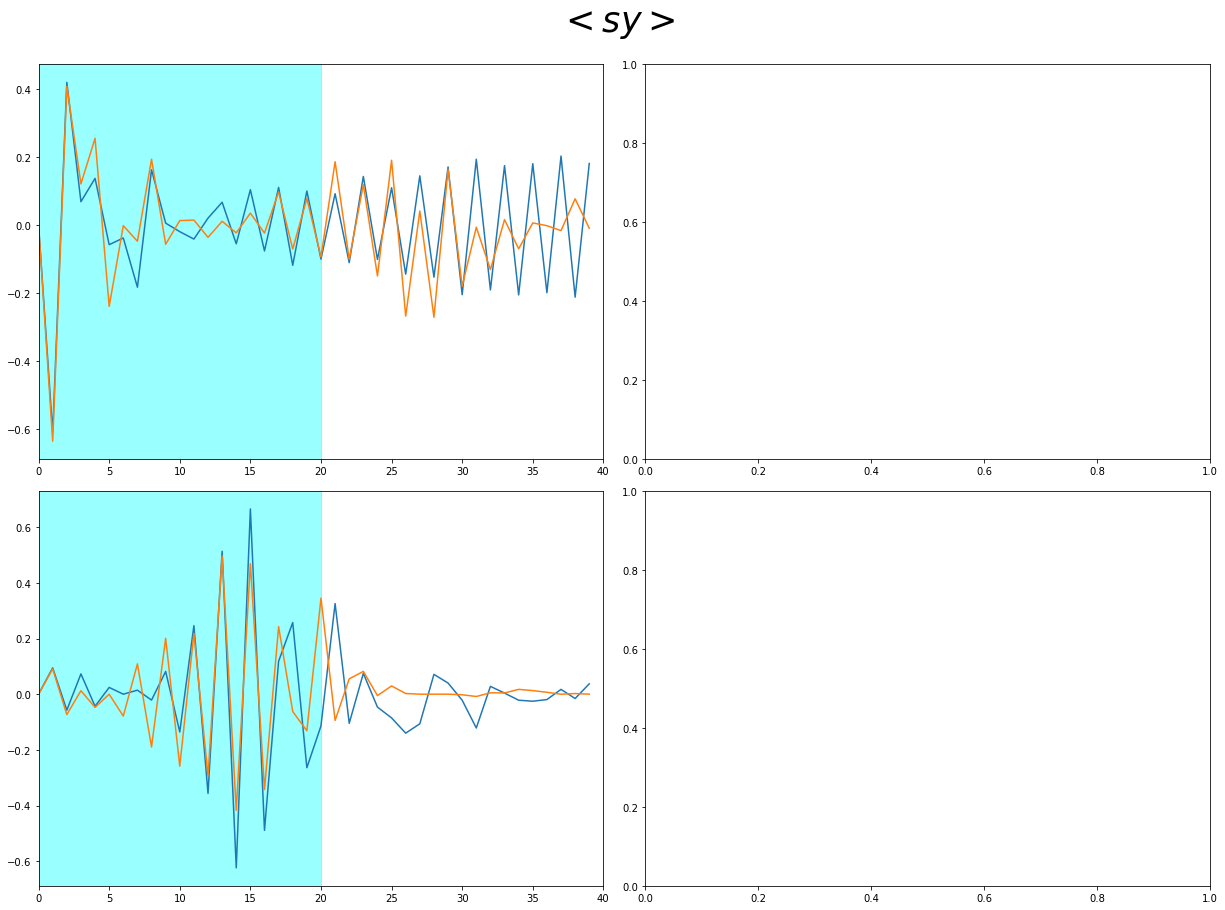

In [28]:
# 60000 samples zz_z_xr
l=L+1
fig, axes = plt.subplots(2, 2, figsize=(17,12))
fig.tight_layout()
fig.suptitle(r'$<sy>$' ,size=35, y=1.05)
for j in range(2):
    for k in range(2*j,2*(j+1)):
        
        axes[k-2*j,j].plot(taulist,np.swapaxes(np.array(y_test_12),1,2)[k][l])
        axes[k-2*j,j].plot(taulist,np.swapaxes(np.array(y_predict_12),1,2)[k][l])
        #axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test_6),1,2)[k][l],'--')
        axes[k-2*j,j].axvspan(0, 20, color='cyan', alpha=0.4)
        axes[k-2*j,j].set_xlim(0,40)
        
legend=fig.legend(('M=8','predicted'),loc='upper right',ncol=3)
#legend.draggable()
plt.subplots_adjust(right=0.95)

